In [42]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [43]:
# myimshow provided in assignments
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [44]:
transform = tv.transforms.Compose([
            tv.transforms.Resize((256,256)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5))
            ])
# Prepare the input image
photo_path = 'photo.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:]
p = p.to(device)

# Stye image the network was trained with
art_path = 'picasso.jpg'
art = Image.open(art_path)
art = transform(art)
#styleimage = styleimage[None,:,:,:]
art = art.to(device)

In [45]:
# Class to implement conv layer with stride 1/2 for use in the ImageTransorm class
class UpsampleConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [46]:
# Image Transorm matrix as described by Johnson et al
class ImageTransform(torch.nn.Module):
    def __init__(self):
        super(ImageTransform, self).__init__()
    
        self.pad = torch.nn.ReflectionPad2d((40,40,40,40))
        self.conv1 = torch.nn.Conv2d(3,32,9,padding=4)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32,64,3,stride=2,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64,128,3,stride=2,padding=1)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.res1 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res2 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res3 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res4 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res5 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.conv4 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.conv5 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.bn5 = torch.nn.BatchNorm2d(32)
        self.conv6 = torch.nn.Conv2d(32,3,9,padding=4)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
    
        h = self.pad(x)
        
        h = F.relu(self.bn1(self.conv1(h)))
        
        h = F.relu(self.bn2(self.conv2(h)))
        
        h = F.relu(self.bn3(self.conv3(h)))
        
        h = F.relu(h[:,:,2:82,2:82] + self.res1(h)) 
        
        h = F.relu(h[:,:,2:78,2:78] + self.res2(h))
        
        h = F.relu(h[:,:,2:74,2:74] + self.res3(h))
        
        h = F.relu(h[:,:,2:70,2:70] + self.res4(h))
        
        h = F.relu(h[:,:,2:66,2:66] + self.res4(h))
        
        h = F.relu(self.bn4(self.conv4(h)))
        
        h = F.relu(self.bn5(self.conv5(h)))
        
        h = self.conv6(h)
        
        y = (self.tanh(h) + 1) / 2
        return y

<IPython.core.display.Javascript object>


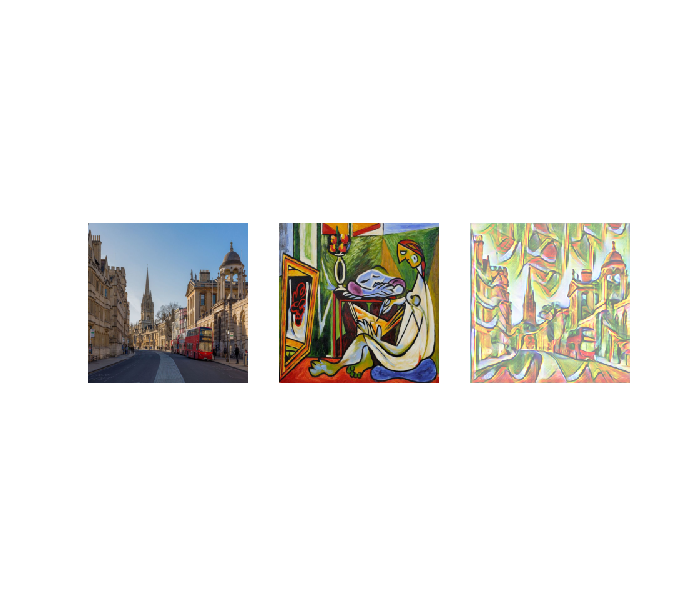

In [47]:
# Show stylized image using network as described in Johnson et al with a style weight of 30
fig1, axes1 = plt.subplots(ncols=3, nrows=1, figsize=(7,6))

model = torch.load('JohnsonModelSW30')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
inputimage = p[0]

myimshow(inputimage, axes1[0])
myimshow(art, axes1[1])
myimshow(stylized_image, axes1[2])

In [48]:
# Child class of the nntools NeuralNetwork class
class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [49]:
# UDnCNN class from Assignment 4. Used in place of ImageTransform for experimentation
class UDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
        
    def forward(self, x):
        D = self.D
        h1 = F.relu(self.conv[0](x))
        h = h1
        
        features = []
        features.append(h1)
        indeces = []
        
        # Contracting
        for k in range(int(D/2 - 1)):
            r = F.relu(self.bn[k](self.conv[k + 1](h)))
            h, ind = F.max_pool2d(r, kernel_size=2, return_indices=True)
            features.append(h)
            indeces.append(ind)
            
        inner1 = F.relu(self.bn[int(D/2 - 1)](self.conv[int(D/2)](features[int(D/2 - 1)])))
        inner2 = F.relu(self.bn[int(D/2)](self.conv[int(D/2)+1](inner1)))
        
        h = inner2
        
        # Expanding
        for k in range(int(D/2 + 1), D):
            p = F.max_unpool2d((h + features[D-k])/np.sqrt(2), indices=indeces[D-k-1], 
                               kernel_size=2, output_size=features[D-k-1].shape)
            h = F.relu(self.bn[k](self.conv[k + 1](p)))
        
        
        y = self.conv[D + 1]((h + h1) / np.sqrt(2)) + x
                                  
        return y

<IPython.core.display.Javascript object>


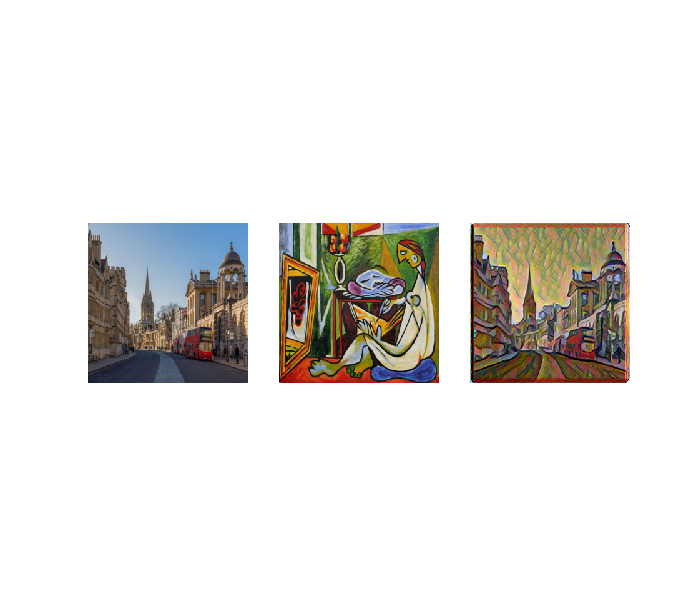

In [50]:
# Show stylized image using UDnCNN network of depth D=4
fig1, axes1 = plt.subplots(ncols=3, nrows=1, figsize=(7,6))

model = torch.load('UDnCNNModelD4')

stylized_image = model(p)
stylized_image = stylized_image.detach().cpu()
stylized_image = stylized_image[0]
inputimage = p[0]

myimshow(inputimage, axes1[0])
myimshow(art, axes1[1])
myimshow(stylized_image, axes1[2])